In [1]:
from tqdm import tqdm
from typing import List, Dict
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from flowprintOptimal.sekigo.core.flowRepresentation import FlowRepresentation,PacketFlowRepressentation, TimeslotRepresentation
from flowprintOptimal.sekigo.dataAnalysis.vNATDataFrameProcessor import VNATDataFrameProcessor
from flowprintOptimal.sekigo.core.flowConfig import FlowConfig
import random
from flowprintOptimal.sekigo.flowUtils.flowDatasets import PacketFlowDataset, DDQNActivityDataset
from torch.utils.data import Dataset,DataLoader
from torchsampler import ImbalancedDatasetSampler
from sklearn.model_selection import train_test_split
from flowprintOptimal.sekigo.flowUtils.commons import normalizePacketRep
import os
from joblib import Parallel, delayed
from flowprintOptimal.sekigo.flowUtils.commons import saveFlows,loadFlows
from flowprintOptimal.sekigo.dataAnalysis.dataFrameProcessor import UTMobileNetProcessor
from flowprintOptimal.sekigo.flowUtils.dataGetter import getTrainTestOOD
from sklearn.metrics import confusion_matrix
import json
import torch
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
device = torch.device("cpu")#torch.device("cuda" if torch.cuda.is_available() else "cpu")
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMNetwork,TransformerGenerator,CNNNetwork1D
#device = torch.device("cpu")
from flowprintOptimal.sekigo.utils.evaluations import Evaluator,EarlyEvaluation
from flowprintOptimal.sekigo.utils.documentor import Documenter
import seaborn
from flowprintOptimal.sekigo.flowUtils.commons import dropPacketFromPacketRep
from flowprintOptimal.sekigo.flowUtils.packetDropping import getPacketDroppedPacketDataset, getPacketDroppedTimeslotDataset
from flowprintOptimal.sekigo.flowUtils.conversions import convertPacketRepToTimeslotRepEffecient

In [2]:
packet_documenter = Documenter.load(name="vnat_ood")
timeslot_documenter = Documenter.load("vnat_timeslot_ood")

packet_evaluator = EarlyEvaluation(min_steps= packet_documenter.configs["memory_fillter_config"]["min_length"], device= device, model= packet_documenter.early_model)
timeslot_evaluator = EarlyEvaluation(min_steps= timeslot_documenter.configs["memory_fillter_config"]["min_length"], device= device, model= timeslot_documenter.early_model)

In [3]:
packet_evaluator.getMetrices(dataset= packet_documenter.test_dataset, ood_dataset= packet_documenter.ood_dataset)

{'micro_f1': 0.9961464354527938,
 'macro_f1': 0.9942848457631964,
 'accuracy': 0.9961464354527938,
 'cm': array([[ 68,   0,   0],
        [  0, 330,   1],
        [  1,   0, 119]]),
 'time': 3.8921001926782273,
 'time_std': 1.615172289163022,
 'incorrect_ood': 0.0,
 'ood_accuracy': 1.0,
 'ood_time': 14.96078431372549}

In [4]:
packet_evaluator.getMetrices(dataset= getPacketDroppedPacketDataset(packet_dataset= packet_documenter.test_dataset,max_drop_rate= .08),
                              ood_dataset= getPacketDroppedPacketDataset(packet_dataset= packet_documenter.ood_dataset, max_drop_rate= .08))

{'micro_f1': 0.974903474903475,
 'macro_f1': 0.9729441930618402,
 'accuracy': 0.974903474903475,
 'cm': array([[ 67,   1,   0],
        [  0, 319,  11],
        [  1,   0, 119]]),
 'time': 3.9787644787644787,
 'time_std': 1.7324778655348985,
 'incorrect_ood': 0.0019267822736030828,
 'ood_accuracy': 1.0,
 'ood_time': 14.96078431372549}

In [5]:
timeslot_evaluator.getMetrices(dataset= timeslot_documenter.test_dataset, ood_dataset= timeslot_documenter.ood_dataset)

{'micro_f1': 0.9980732177263969,
 'macro_f1': 0.9970280989888832,
 'accuracy': 0.9980732177263969,
 'cm': array([[ 67,   1,   0],
        [  0, 331,   0],
        [  0,   0, 120]]),
 'time': 7.853564547206166,
 'time_std': 4.353120136644637,
 'incorrect_ood': 0.0,
 'ood_accuracy': 1.0,
 'ood_time': 14.96078431372549}

In [9]:
label_to_index = timeslot_documenter.test_dataset.label_to_index
flow_config = timeslot_documenter.test_dataset.flow_config
aug = timeslot_documenter.test_dataset.aug

dropped_timeslot_test_dataset = getPacketDroppedTimeslotDataset(packet_dataset= packet_documenter.test_dataset, 
                                label_to_index= label_to_index, flow_config= flow_config,aug= aug, max_drop_rate= .05)
dropped_timeslot_ood_dataset = getPacketDroppedTimeslotDataset(packet_dataset= packet_documenter.ood_dataset, 
                                                               label_to_index= packet_documenter.ood_dataset.label_to_index, flow_config= flow_config, aug= None,
                                                               max_drop_rate= 0
                                                               )

timeslot_evaluator.getMetrices(dataset= dropped_timeslot_test_dataset, ood_dataset= dropped_timeslot_ood_dataset)

{'micro_f1': 0.9961464354527938,
 'macro_f1': 0.9940909898702683,
 'accuracy': 0.9961464354527938,
 'cm': array([[ 67,   1,   0],
        [  1, 330,   0],
        [  0,   0, 120]]),
 'time': 7.932562620423892,
 'time_std': 5.063496566525877,
 'incorrect_ood': 0.0,
 'ood_accuracy': 0.006535947712418301,
 'ood_time': 42.61655773420479}

In [36]:
evaluator.getMetrices(dataset= timeslot_documenter.test_dataset)

{'micro_f1': 0.9705412422608348,
 'macro_f1': 0.9357989718289064,
 'accuracy': 0.9705412422608348,
 'cm': array([[3757,   15,    2,    1,    1],
        [  16, 4524,   43,   29,    1],
        [   9,  122,  399,   17,    1],
        [  10,   13,    4,  898,    1],
        [   8,    1,    1,    0,  141]]),
 'time': 10.267425604154184,
 'incorrect_ood': 0.0008979347500748278}

In [24]:
timeslot_documenter.test_dataset.flows[0].down_packets

array([[0, 1, 2, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [25]:

train_flows = loadFlows(path= "data/ClassificationOnlyFlows/unibs/train_packet_flows.pkl", cls= PacketFlowRepressentation)
test_flows = loadFlows(path= "data/ClassificationOnlyFlows/unibs/test_packet_flows.pkl", cls= PacketFlowRepressentation)



old_train_dataset : PacketFlowDataset = documenter.train_dataset
train_dataset = PacketFlowDataset(flows= train_flows, label_to_index= old_train_dataset.label_to_index, aug= old_train_dataset.aug,
                                  fixed_length= old_train_dataset.fixed_length, truncate_length= 15
                                  )

old_test_dataset : PacketFlowDataset = documenter.test_dataset
test_dataset = PacketFlowDataset(flows= test_flows, label_to_index= old_test_dataset.label_to_index, aug= old_test_dataset.aug,
                                  fixed_length= old_test_dataset.fixed_length, truncate_length= 15
                                  )


old_ood_dataset : PacketFlowDataset = documenter.ood_dataset
#ood_dataset = PacketFlowDataset(flows= ood_flows, label_to_index= old_ood_dataset.label_to_index, aug= old_ood_dataset.aug,fixed_length= old_ood_dataset.fixed_length, truncate_length= 15

documenter.train_dataset = train_dataset
documenter.test_dataset = test_dataset
documenter.document("unibs")


In [6]:
"""
train_flows = documenter.train_dataset.flows
train_label_to_index = documenter.train_dataset.label_to_index
train_aug = documenter.train_dataset.aug

test_flows = documenter.test_dataset.flows
test_label_to_index = documenter.test_dataset.label_to_index
test_aug = documenter.test_dataset.aug

ood_flows = documenter.ood_dataset.flows
ood_label_to_index = documenter.ood_dataset.label_to_index
ood_aug = documenter.ood_dataset.aug


new_train_dataset = PacketFlowDataset(flows= train_flows,label_to_index= train_label_to_index, aug= train_aug)
new_test_dataset =  PacketFlowDataset(flows= test_flows,label_to_index= test_label_to_index, aug= test_aug)
new_ood_dataset =  PacketFlowDataset(flows= ood_flows,label_to_index= ood_label_to_index, aug= ood_aug)

documenter.train_dataset = new_train_dataset
documenter.test_dataset = new_test_dataset
documenter.ood_dataset = new_ood_dataset
#documenter.document("new_UNIBS_no_sample_ood_dueling")
"""

'\ntrain_flows = documenter.train_dataset.flows\ntrain_label_to_index = documenter.train_dataset.label_to_index\ntrain_aug = documenter.train_dataset.aug\n\ntest_flows = documenter.test_dataset.flows\ntest_label_to_index = documenter.test_dataset.label_to_index\ntest_aug = documenter.test_dataset.aug\n\nood_flows = documenter.ood_dataset.flows\nood_label_to_index = documenter.ood_dataset.label_to_index\nood_aug = documenter.ood_dataset.aug\n\n\nnew_train_dataset = PacketFlowDataset(flows= train_flows,label_to_index= train_label_to_index, aug= train_aug)\nnew_test_dataset =  PacketFlowDataset(flows= test_flows,label_to_index= test_label_to_index, aug= test_aug)\nnew_ood_dataset =  PacketFlowDataset(flows= ood_flows,label_to_index= ood_label_to_index, aug= ood_aug)\n\ndocumenter.train_dataset = new_train_dataset\ndocumenter.test_dataset = new_test_dataset\ndocumenter.ood_dataset = new_ood_dataset\n#documenter.document("new_UNIBS_no_sample_ood_dueling")\n'

In [7]:
documenter.configs["description"], documenter.configs

('utmobilenet balanced datagettter V2 not OOD',
 {'name': 'utmobilenet',
  'description': 'utmobilenet balanced datagettter V2 not OOD',
  'common_config': {'max_timesteps': 15, 'min_timesteps': 8},
  'full_model_kwargs': {'lstm_hidden_size': 256,
   'layers': 2,
   'lstm_input_size': 3,
   'output_dim': 13},
  'early_model_kwargs': {'lstm_input_size': 3,
   'lstm_hidden_size': 256,
   'layers': 2,
   'output_dim': 14},
  'data_config': {'dataset_name': 'utmobilenet2021',
   'subsampleConfig': None,
   'max_flow_length': 100,
   'test_size': 0.2,
   'ood_classes': [],
   'do_balance': False,
   'data_type': 'packet_representation'},
  'rewarder_config': {'l': 0.5, 'num_labels': 13, 'max_length': 15},
  'dataset_config': {'aug': [0, 0.2]},
  'memory_fillter_config': {'ood_config': {'ood_aug': [0.6, 0.9],
    'ood_prob': 0.2},
   'min_length': 1,
   'use_balancer': False},
  'full_trainer_config': {'use_sampler': False},
  'early_trainer_config': {'use_sampler': False}})

In [8]:
documenter.configs["data_config"]

{'dataset_name': 'utmobilenet2021',
 'subsampleConfig': None,
 'max_flow_length': 100,
 'test_size': 0.2,
 'ood_classes': [],
 'do_balance': False,
 'data_type': 'packet_representation'}

In [9]:
evaluator = EarlyEvaluation(min_steps= documenter.configs["memory_fillter_config"]["min_length"], device= device, model= documenter.early_model)
all_evaluator = Evaluator(model= documenter.full_model,device= device)

In [10]:
evaluator.getMetrices(dataset= documenter.test_dataset, ood_dataset= documenter.ood_dataset)

{'micro_f1': 0.8856584412411435,
 'macro_f1': 0.8668713886926953,
 'accuracy': 0.8856584412411435,
 'cm': array([[143,   0,   8,   0,   1,   3,   0,   0,   0,   1,   0,   0,   0],
        [  0, 376,   0,   3,   0,   1,   4,   3,   1,   3,   0,   2,   0],
        [  2,   0, 379,   0,   0,   2,   4,   1,   2,   0,  11,   0,   0],
        [  2,   0,   1, 358,   2,  18,   1,   1,   0,   3,   1,   0,   0],
        [  0,   0,   0,   1,  87,   3,   0,   8,   0,   1,   0,   2,   1],
        [  0,   5,   0,  25,   2, 358,   0,   4,   0,   2,   0,   8,   1],
        [  0,   0,   7,   2,   0,   0, 352,   3,  11,   2,   1,   3,  25],
        [  0,   0,   0,   8,   0,   6,   1, 256,   2,   1,   0,   2,   1],
        [  0,   2,   0,   4,   1,   2,  41,   0, 336,   2,   4,   7,   9],
        [  0,   1,   1,   1,   0,   5,   3,   4,   1, 277,   0,  21,   5],
        [  6,   0,  11,   0,   0,   4,   9,   1,  17,   2, 379,   0,   0],
        [  0,   2,   0,   5,   0,   0,   1,   3,   0,   8,   0, 266,  

In [12]:
evaluator.getMetrices(dataset= getPacketDroppedPacketDataset(documenter.test_dataset, max_drop_rate= .08), ood_dataset= documenter.ood_dataset)

50
2
50
0
21
1
24
1
50
2
21
0
38
2
28
1
50
0
50
1
22
1
50
1
21
1
50
2
31
2
50
2
50
3
50
3
50
1
26
1
50
0
43
1
50
0
16
0
25
1
50
3
50
1
50
3
50
3
50
1
19
0
28
1
23
0
50
2
50
1
21
0
50
2
50
2
21
1
21
0
20
1
22
1
50
2
50
2
50
0
50
1
23
1
50
0
23
0
29
1
23
0
50
1
21
0
50
0
50
3
50
1
30
1
50
1
50
3
19
1
50
0
50
1
50
1
50
3
50
3
24
1
22
0
23
1
23
1
22
0
22
1
26
0
50
2
50
0
50
0
25
0
42
1
50
1
26
1
38
0
50
1
23
0
19
0
50
1
50
2
25
1
50
2
28
0
16
0
50
2
24
0
29
2
50
0
50
3
18
0
50
1
25
0
22
1
50
3
50
3
28
1
50
1
50
0
27
0
18
0
50
2
20
0
28
1
20
0
50
1
16
0
22
0
50
3
21
1
50
0
23
0
50
2
24
1
50
3
19
0
50
1
50
0
16
0
19
1
50
0
50
0
21
0
16
0
41
2
17
0
50
3
50
0
50
0
50
1
50
0
22
0
50
1
50
2
50
3
50
1
50
0
30
0
24
1
27
1
29
2
25
0
50
0
50
2
25
1
21
0
21
0
16
0
50
1
24
0
50
0
50
2
50
1
50
2
36
1
33
0
50
2
44
3
40
0
20
0
50
3
50
3
50
1
50
3
20
0
50
2
21
0
25
1
24
0
50
2
50
1
50
3
50
3
50
1
50
3
50
2
43
1
50
0
25
1
50
3
22
1
18
0
50
3
27
1
50
2
22
1
27
0
50
3
20
0
28
1
50
0
50
0
50
1
50
3
50
0
50
0


{'micro_f1': 0.8260762607626077,
 'macro_f1': 0.8051827182627006,
 'accuracy': 0.8260762607626077,
 'cm': array([[134,   0,   8,   0,   1,   3,   0,   0,   0,   1,   9,   0,   0],
        [  0, 358,   0,   3,   0,   7,   4,   2,   4,   5,   1,   4,   0],
        [  2,   0, 349,   0,   0,   2,   5,   1,   4,   1,  36,   0,   0],
        [  2,   0,   1, 344,   4,  27,   1,   0,   0,   3,   1,   1,   0],
        [  0,   6,   0,   1,  74,   7,   0,   7,   1,   2,   0,   3,   1],
        [  0,  13,   0,  27,   4, 339,   0,   4,   1,   3,   1,   7,   3],
        [  0,  15,   6,   2,   0,   7, 312,   2,  22,   4,   7,   4,  20],
        [  0,  15,   0,   9,   7,   7,   1, 222,   8,   1,   0,   2,   1],
        [  0,  12,   0,   4,   1,   6,  46,   0, 314,   3,   5,   5,   6],
        [  0,   3,   1,   1,   0,   6,   8,   6,   4, 257,   1,  27,   8],
        [  6,   5,  14,   0,   0,   5,   7,   1,  17,   3, 369,   0,   0],
        [  2,   6,   1,   5,   0,   4,   9,   4,   2,  15,   0, 234,  

In [7]:
preds, time, labels = evaluator.predictOnDataset(dataset= documenter.test_dataset)

TypeError: EarlyEvaluation.predictOnDataset() got an unexpected keyword argument 'enforce_prediction'

In [29]:
np.unique(preds)

array([0, 1, 2, 3, 4])

In [30]:
documenter.test_dataset[0]["data"].shape

(20, 3)

In [22]:
timesteps = np.array(list(map(lambda x : x["data"].shape[0], documenter.test_dataset)))

<Axes: >

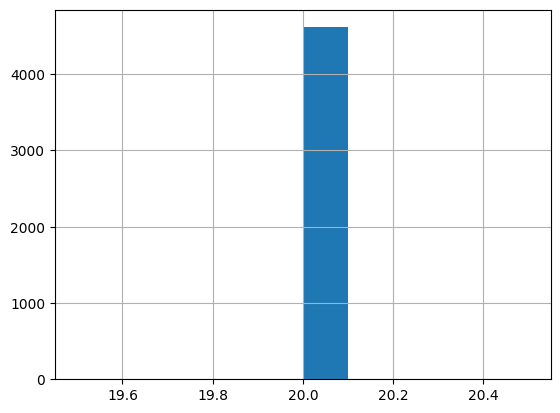

In [23]:
pd.Series(timesteps[preds == labels]).hist()

<Axes: >

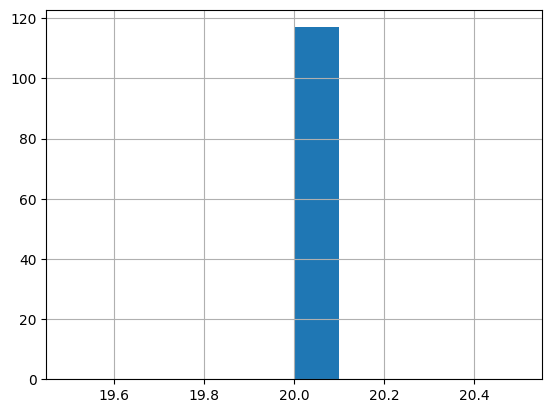

In [24]:
pd.Series(timesteps[preds != labels]).hist()

In [31]:
metrices = evaluator.getMetrices(dataset= documenter.test_dataset, ood_dataset= documenter.ood_dataset, enforce_prediction= True)
print(metrices)

{'micro_f1': 0.9747770141833602, 'macro_f1': 0.9468484765777238, 'accuracy': 0.9747770141833602, 'cm': array([[7755,   60,    8,   14,    1],
       [ 196,  707,    4,    6,    0],
       [   8,    7, 3798,    0,    5],
       [   9,   11,    2,  880,    1],
       [   3,    2,    8,    0,  193]]), 'incorrect_ood': 0.0, 'time': 7.104912998976459}


In [16]:
all_evaluator.getMetrices(dataset= documenter.test_dataset)

{'micro_f1': 0.8724523339907956,
 'macro_f1': 0.8635566086666779,
 'accuracy': 0.8724523339907956,
 'cm': array([[ 891,    0,   88,    7,  136],
        [  10, 1075,    4,    1,    2],
        [  35,    2,  507,    1,   22],
        [  23,    4,    7,  940,    8],
        [ 173,    4,   51,    4,  568]]),
 'incorrect_ood': 0.0}

In [18]:
info = documenter.getScores(device= device)

In [19]:
train_counts, test_counts = info["train_dataset_counts"],info["test_dataset_counts"]
train_counts , test_counts = dict(train_counts), dict(test_counts)

In [20]:
train_counts

{'google-maps': 2584,
 'netflix': 1680,
 'reddit': 1295,
 'youtube': 1031,
 'facebook': 1028,
 'instagram': 994,
 'pinterest': 994,
 'google-drive': 709,
 'spotify': 699,
 'twitter': 682,
 'gmail': 400,
 'hangout': 351,
 'messenger': 329}

In [10]:
total_flows = train_counts.copy()

for key in total_flows:
    total_flows[key] += test_counts[key]

In [11]:
total_flows

{'BROWSERS': 18820, 'P2P': 14175, 'MAIL': 4432, 'OTHER': 2368, 'Skype': 499}

In [13]:
info["full_metrices"]["cm"]

array([[2033,  122,    0,    4],
       [  67, 2129,    0,    5],
       [   0,    2, 1086,    0],
       [   2,    0,    0, 1789]])

In [11]:
info["early_metrices"]["cm"]

array([[2006,  104,    4,   28],
       [ 157, 2035,    0,    6],
       [   1,    2, 1081,    4],
       [   2,    8,    0, 1781]])

In [12]:
info["labels"]

['streaming', 'FT', 'chat', 'control']